In [1]:
from AttentionModule import Conv2d_Attn

import torch
from torch import nn
from torchvision import models, datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import re
import numpy as np

In [2]:
resnet_pretrained = models.resnet50(pretrained=True)
nn.Conv2d = Conv2d_Attn
resnet_attn = models.resnet50()
resnet_attn.load_state_dict(resnet_pretrained.state_dict(), strict=False)

In [3]:
# This block turns 'layer1.0.downsample.0.weight' to 'layer1[0].downsample[0].weight'
param_keys = list(resnet_attn.state_dict().keys())
formatted_keys = []
for k in param_keys:
    found = re.findall(r'\.[\d]{1,2}\.', k)
    if len(found):
        for f in found:
            k = k.replace(f, '[{}].'.format(f.strip('.')))
    formatted_keys.append(k)

In [4]:
# This block turn off gradient up for all params except attn_weights
def turn_off_grad_except(lst=[]):
    for k in formatted_keys:
        obj = eval('resnet_attn.'+k)
        for kw in lst:
            if not kw in k:
                obj.requires_grad = False
            else:
                obj.requires_grad = True

In [5]:
resnet_attn.fc = nn.Linear(resnet_attn.fc.in_features, 144)

Start training

In [6]:
batch_size = 32

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [transforms.ToTensor(),
     normalize])

trainset = torchvision.datasets.ImageFolder(root='./data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [8]:
total_imgs = len(trainset.imgs)

In [9]:
resnet_attn = resnet_attn.cuda()

In [10]:
total_attn_params = 0
for k in formatted_keys:
    obj = eval('resnet_attn.'+k)
    if 'attn_weights' in k:
        total_attn_params += np.prod(obj.shape)
print("Total number of attention parameters", total_attn_params)

Total number of attention parameters 26560


We want the attention parameters to diverge from 1, therefore we penalize element-wise square loss as $\lambda (1 \times \text{# params} - (x - 1)^2)$

But this is too big a number,
let's try: 
$- (x - 1)^2$ for now

In [11]:
_lambda = 1e-2 #set default

In [12]:
def get_params_objs(name, net='resnet_attn'):
    res = []
    for k in formatted_keys:
        obj = eval(f'{net}.'+k)
        if name in k:
            res.append(obj)
    return res

In [13]:
def compute_attn_loss(n_params=26560):
    attns = get_params_objs('attn_weights')
    penality = sum([torch.pow(t - 1,2).mean() for t in attns])
    return _lambda*(- penality)

In [14]:
print_every = 5

In [15]:
def train_one_epoch(add_attn=True):
    cls_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet_attn.parameters()))
    
    running_loss = 0.0
    running_attn_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()

        optimizer.zero_grad()
        outputs = resnet_attn(inputs)
        clf_loss = cls_criterion(outputs, labels)
        attn_loss = compute_attn_loss()
        if add_attn:
            loss = clf_loss + attn_loss
        else:
            loss = clf_loss

        loss.backward()
        optimizer.step()

        running_loss += clf_loss.data[0]
        running_attn_loss += attn_loss.data[0]

        if i % print_every == 0:
            print('[%5d] iter, [%2f] epoch, classifer loss: %.3f, attn_loss: %.5f ' %
                  (i + 1, i*batch_size/total_imgs, running_loss/print_every, running_attn_loss/print_every))
            running_loss = 0.0
            running_attn_loss = 0.0

In [16]:
from tqdm import tqdm
def score(net=resnet_attn, batch_size=batch_size):
    trainset = torchvision.datasets.ImageFolder(root='./data/train', transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    
    valset = torchvision.datasets.ImageFolder(root='./data/val', transform=transform)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    
    train_correct = 0
    val_correct = 0
    
    for inp, label in tqdm(iter(trainloader)):
        _, idx = net(Variable(inp).cuda()).max(1)
        train_correct += int(sum(idx.cpu().data == label))
    
    for inp, label in tqdm(iter(valloader)):
        _, idx = net(Variable(inp).cuda()).max(1)
        val_correct += int(sum(idx.cpu().data == label))
    
    return {
        'train_accu': train_correct/len(trainset),
        'val_accu': val_correct/len(valset)
    }

Train a fresh fc layer. 
`turn_off_grad_except([])` turns off grads for all weights but the fc layer

In [17]:
print_every = 20

In [18]:
train_in_order = [['fc'], ['attn_weights'], ['bn'], ['attn_weights'], ['bn']]*5

In [19]:
_lambda = 5e-1

In [20]:
scores = []

In [21]:
for train_layer in train_in_order:
    print(f"Training {train_layer}")
    
    turn_off_grad_except(train_layer)
    
    if train_layer[0] == 'bn':
        resnet_attn.train() 
    else:
        resnet_attn.eval()
        
    train_one_epoch(add_attn= train_layer[0] == 'attn_weights' )
    
    s = score(batch_size=32)
    print(s)
    scores.append(s)

Training ['fc']
[    1] iter, [0.000000] epoch, classifer loss: 0.252, attn_loss: 0.00000 
[   21] iter, [0.078422] epoch, classifer loss: 4.761, attn_loss: 0.00000 
[   41] iter, [0.156844] epoch, classifer loss: 4.150, attn_loss: 0.00000 
[   61] iter, [0.235265] epoch, classifer loss: 3.622, attn_loss: 0.00000 
[   81] iter, [0.313687] epoch, classifer loss: 3.510, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 3.324, attn_loss: 0.00000 
[  121] iter, [0.470531] epoch, classifer loss: 3.277, attn_loss: 0.00000 
[  141] iter, [0.548952] epoch, classifer loss: 3.195, attn_loss: 0.00000 
[  161] iter, [0.627374] epoch, classifer loss: 3.228, attn_loss: 0.00000 
[  181] iter, [0.705796] epoch, classifer loss: 2.899, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 2.920, attn_loss: 0.00000 
[  221] iter, [0.862639] epoch, classifer loss: 3.033, attn_loss: 0.00000 
[  241] iter, [0.941061] epoch, classifer loss: 3.026, attn_loss: 0.00000 


100%|██████████| 55/55 [00:14<00:00,  3.84it/s]

{'train_accu': 0.37005268962136995, 'val_accu': 0.29874572405929306}
Training ['attn_weights']


[    1] iter, [0.000000] epoch, classifer loss: 0.142, attn_loss: 0.00000 
[   21] iter, [0.078422] epoch, classifer loss: 2.426, attn_loss: -0.00054 
[   41] iter, [0.156844] epoch, classifer loss: 2.408, attn_loss: -0.00181 
[   61] iter, [0.235265] epoch, classifer loss: 2.381, attn_loss: -0.00348 
[   81] iter, [0.313687] epoch, classifer loss: 2.344, attn_loss: -0.00603 
[  101] iter, [0.392109] epoch, classifer loss: 2.197, attn_loss: -0.00968 
[  121] iter, [0.470531] epoch, classifer loss: 2.168, attn_loss: -0.01446 
[  141] iter, [0.548952] epoch, classifer loss: 2.374, attn_loss: -0.02049 
[  161] iter, [0.627374] epoch, classifer loss: 2.260, attn_loss: -0.02784 
[  181] iter, [0.705796] epoch, classifer loss: 2.209, attn_loss: -0.03694 
[  201] iter, [0.784218] epoch, classifer loss: 2.240, attn_loss: -0.04785 
[  221] iter, [0.862639] epoch, classifer loss: 2.224, attn_loss: -0.06043 
[  241] iter, [0.941061] epoch, classifer loss: 2.276, attn_loss: -0.07488 


100%|██████████| 55/55 [00:14<00:00,  3.82it/s]

{'train_accu': 0.45251807376546993, 'val_accu': 0.36488027366020526}
Training ['bn']


[    1] iter, [0.000000] epoch, classifer loss: 0.182, attn_loss: -0.00481 
[   21] iter, [0.078422] epoch, classifer loss: 2.983, attn_loss: -0.09620 
[   41] iter, [0.156844] epoch, classifer loss: 2.654, attn_loss: -0.09620 
[   61] iter, [0.235265] epoch, classifer loss: 2.593, attn_loss: -0.09620 
[   81] iter, [0.313687] epoch, classifer loss: 2.620, attn_loss: -0.09620 
[  101] iter, [0.392109] epoch, classifer loss: 2.421, attn_loss: -0.09620 
[  121] iter, [0.470531] epoch, classifer loss: 2.423, attn_loss: -0.09620 
[  141] iter, [0.548952] epoch, classifer loss: 2.475, attn_loss: -0.09620 
[  161] iter, [0.627374] epoch, classifer loss: 2.343, attn_loss: -0.09620 
[  181] iter, [0.705796] epoch, classifer loss: 2.376, attn_loss: -0.09620 
[  201] iter, [0.784218] epoch, classifer loss: 2.437, attn_loss: -0.09620 
[  221] iter, [0.862639] epoch, classifer loss: 2.330, attn_loss: -0.09620 
[  241] iter, [0.941061] epoch, classifer loss: 2.381, attn_loss: -0.09620 


100%|██████████| 55/55 [00:14<00:00,  3.70it/s]

{'train_accu': 0.4620757260139689, 'val_accu': 0.3774230330672748}
Training ['attn_weights']


[    1] iter, [0.000000] epoch, classifer loss: 0.113, attn_loss: -0.00481 
[   21] iter, [0.078422] epoch, classifer loss: 1.921, attn_loss: -0.10265 
[   41] iter, [0.156844] epoch, classifer loss: 2.011, attn_loss: -0.11538 
[   61] iter, [0.235265] epoch, classifer loss: 1.946, attn_loss: -0.12893 
[   81] iter, [0.313687] epoch, classifer loss: 1.912, attn_loss: -0.14371 
[  101] iter, [0.392109] epoch, classifer loss: 2.025, attn_loss: -0.15951 
[  121] iter, [0.470531] epoch, classifer loss: 1.995, attn_loss: -0.17632 
[  141] iter, [0.548952] epoch, classifer loss: 1.790, attn_loss: -0.19485 
[  161] iter, [0.627374] epoch, classifer loss: 2.081, attn_loss: -0.21505 
[  181] iter, [0.705796] epoch, classifer loss: 1.914, attn_loss: -0.23668 
[  201] iter, [0.784218] epoch, classifer loss: 1.908, attn_loss: -0.26024 
[  221] iter, [0.862639] epoch, classifer loss: 2.040, attn_loss: -0.28585 
[  241] iter, [0.941061] epoch, classifer loss: 1.982, attn_loss: -0.31354 


100%|██████████| 55/55 [00:14<00:00,  3.82it/s]

{'train_accu': 0.513662541355226, 'val_accu': 0.4064994298745724}
Training ['bn']


[    1] iter, [0.000000] epoch, classifer loss: 0.112, attn_loss: -0.01756 
[   21] iter, [0.078422] epoch, classifer loss: 2.135, attn_loss: -0.35112 
[   41] iter, [0.156844] epoch, classifer loss: 2.071, attn_loss: -0.35112 
[   61] iter, [0.235265] epoch, classifer loss: 2.259, attn_loss: -0.35112 
[   81] iter, [0.313687] epoch, classifer loss: 2.101, attn_loss: -0.35112 
[  101] iter, [0.392109] epoch, classifer loss: 2.061, attn_loss: -0.35112 
[  121] iter, [0.470531] epoch, classifer loss: 2.093, attn_loss: -0.35112 
[  141] iter, [0.548952] epoch, classifer loss: 2.144, attn_loss: -0.35112 
[  161] iter, [0.627374] epoch, classifer loss: 2.195, attn_loss: -0.35112 
[  181] iter, [0.705796] epoch, classifer loss: 2.145, attn_loss: -0.35112 
[  201] iter, [0.784218] epoch, classifer loss: 2.144, attn_loss: -0.35112 
[  221] iter, [0.862639] epoch, classifer loss: 2.202, attn_loss: -0.35112 
[  241] iter, [0.941061] epoch, classifer loss: 2.216, attn_loss: -0.35112 


100%|██████████| 55/55 [00:14<00:00,  3.69it/s]

{'train_accu': 0.5081485112118613, 'val_accu': 0.40421892816419613}
Training ['fc']


[    1] iter, [0.000000] epoch, classifer loss: 0.082, attn_loss: -0.01756 
[   21] iter, [0.078422] epoch, classifer loss: 2.476, attn_loss: -0.35112 
[   41] iter, [0.156844] epoch, classifer loss: 2.054, attn_loss: -0.35112 
[   61] iter, [0.235265] epoch, classifer loss: 2.011, attn_loss: -0.35112 
[   81] iter, [0.313687] epoch, classifer loss: 1.859, attn_loss: -0.35112 
[  101] iter, [0.392109] epoch, classifer loss: 1.785, attn_loss: -0.35112 
[  121] iter, [0.470531] epoch, classifer loss: 1.765, attn_loss: -0.35112 
[  141] iter, [0.548952] epoch, classifer loss: 1.852, attn_loss: -0.35112 
[  161] iter, [0.627374] epoch, classifer loss: 1.889, attn_loss: -0.35112 
[  181] iter, [0.705796] epoch, classifer loss: 1.921, attn_loss: -0.35112 
[  201] iter, [0.784218] epoch, classifer loss: 1.868, attn_loss: -0.35112 
[  221] iter, [0.862639] epoch, classifer loss: 1.795, attn_loss: -0.35112 
[  241] iter, [0.941061] epoch, classifer loss: 1.786, attn_loss: -0.35112 


100%|██████████| 55/55 [00:14<00:00,  3.83it/s]

{'train_accu': 0.579218233059674, 'val_accu': 0.3979475484606613}
Training ['attn_weights']


[    1] iter, [0.000000] epoch, classifer loss: 0.065, attn_loss: -0.01756 
[   21] iter, [0.078422] epoch, classifer loss: 1.463, attn_loss: -0.36390 
[   41] iter, [0.156844] epoch, classifer loss: 1.439, attn_loss: -0.38864 
[   61] iter, [0.235265] epoch, classifer loss: 1.261, attn_loss: -0.41510 
[   81] iter, [0.313687] epoch, classifer loss: 1.389, attn_loss: -0.44295 
[  101] iter, [0.392109] epoch, classifer loss: 1.379, attn_loss: -0.47185 
[  121] iter, [0.470531] epoch, classifer loss: 1.298, attn_loss: -0.50270 
[  141] iter, [0.548952] epoch, classifer loss: 1.337, attn_loss: -0.53544 
[  161] iter, [0.627374] epoch, classifer loss: 1.303, attn_loss: -0.56985 
[  181] iter, [0.705796] epoch, classifer loss: 1.274, attn_loss: -0.60595 
[  201] iter, [0.784218] epoch, classifer loss: 1.289, attn_loss: -0.64385 
[  221] iter, [0.862639] epoch, classifer loss: 1.223, attn_loss: -0.68411 
[  241] iter, [0.941061] epoch, classifer loss: 1.243, attn_loss: -0.72640 


100%|██████████| 55/55 [00:14<00:00,  3.82it/s]

{'train_accu': 0.6611934811910305, 'val_accu': 0.45381984036488027}
Training ['bn']


[    1] iter, [0.000000] epoch, classifer loss: 0.088, attn_loss: -0.03917 
[   21] iter, [0.078422] epoch, classifer loss: 1.690, attn_loss: -0.78341 
[   41] iter, [0.156844] epoch, classifer loss: 1.551, attn_loss: -0.78341 
[   61] iter, [0.235265] epoch, classifer loss: 1.703, attn_loss: -0.78341 
[   81] iter, [0.313687] epoch, classifer loss: 1.658, attn_loss: -0.78341 
[  101] iter, [0.392109] epoch, classifer loss: 1.539, attn_loss: -0.78341 
[  121] iter, [0.470531] epoch, classifer loss: 1.613, attn_loss: -0.78341 
[  141] iter, [0.548952] epoch, classifer loss: 1.567, attn_loss: -0.78341 
[  161] iter, [0.627374] epoch, classifer loss: 1.505, attn_loss: -0.78341 
[  181] iter, [0.705796] epoch, classifer loss: 1.511, attn_loss: -0.78341 
[  201] iter, [0.784218] epoch, classifer loss: 1.518, attn_loss: -0.78341 
[  221] iter, [0.862639] epoch, classifer loss: 1.682, attn_loss: -0.78341 
[  241] iter, [0.941061] epoch, classifer loss: 1.520, attn_loss: -0.78341 


100%|██████████| 55/55 [00:14<00:00,  3.69it/s]

{'train_accu': 0.645876730792795, 'val_accu': 0.4509692132269099}
Training ['attn_weights']


[    1] iter, [0.000000] epoch, classifer loss: 0.065, attn_loss: -0.03917 
[   21] iter, [0.078422] epoch, classifer loss: 1.194, attn_loss: -0.80629 
[   41] iter, [0.156844] epoch, classifer loss: 1.165, attn_loss: -0.85059 
[   61] iter, [0.235265] epoch, classifer loss: 1.163, attn_loss: -0.89540 
[   81] iter, [0.313687] epoch, classifer loss: 1.111, attn_loss: -0.94173 
[  101] iter, [0.392109] epoch, classifer loss: 1.159, attn_loss: -0.98994 
[  121] iter, [0.470531] epoch, classifer loss: 1.056, attn_loss: -1.03930 
[  141] iter, [0.548952] epoch, classifer loss: 1.115, attn_loss: -1.09085 
[  161] iter, [0.627374] epoch, classifer loss: 1.036, attn_loss: -1.14449 
[  181] iter, [0.705796] epoch, classifer loss: 0.996, attn_loss: -1.20061 
[  201] iter, [0.784218] epoch, classifer loss: 1.045, attn_loss: -1.25944 
[  221] iter, [0.862639] epoch, classifer loss: 1.176, attn_loss: -1.32066 
[  241] iter, [0.941061] epoch, classifer loss: 1.133, attn_loss: -1.38404 


100%|██████████| 55/55 [00:14<00:00,  3.82it/s]

{'train_accu': 0.7142507045705183, 'val_accu': 0.467502850627138}
Training ['bn']


[    1] iter, [0.000000] epoch, classifer loss: 0.050, attn_loss: -0.07339 
[   21] iter, [0.078422] epoch, classifer loss: 1.322, attn_loss: -1.46789 
[   41] iter, [0.156844] epoch, classifer loss: 1.536, attn_loss: -1.46789 
[   61] iter, [0.235265] epoch, classifer loss: 1.411, attn_loss: -1.46789 
[   81] iter, [0.313687] epoch, classifer loss: 1.403, attn_loss: -1.46789 
[  101] iter, [0.392109] epoch, classifer loss: 1.394, attn_loss: -1.46789 
[  121] iter, [0.470531] epoch, classifer loss: 1.446, attn_loss: -1.46789 
[  141] iter, [0.548952] epoch, classifer loss: 1.379, attn_loss: -1.46789 
[  161] iter, [0.627374] epoch, classifer loss: 1.486, attn_loss: -1.46789 
[  181] iter, [0.705796] epoch, classifer loss: 1.428, attn_loss: -1.46789 
[  201] iter, [0.784218] epoch, classifer loss: 1.382, attn_loss: -1.46789 
[  221] iter, [0.862639] epoch, classifer loss: 1.453, attn_loss: -1.46789 
[  241] iter, [0.941061] epoch, classifer loss: 1.427, attn_loss: -1.46789 


100%|██████████| 55/55 [00:14<00:00,  3.70it/s]

{'train_accu': 0.6668300453375812, 'val_accu': 0.4532497149372862}
Training ['fc']


[    1] iter, [0.000000] epoch, classifer loss: 0.045, attn_loss: -0.07339 
[   21] iter, [0.078422] epoch, classifer loss: 1.670, attn_loss: -1.46789 
[   41] iter, [0.156844] epoch, classifer loss: 1.501, attn_loss: -1.46789 
[   61] iter, [0.235265] epoch, classifer loss: 1.266, attn_loss: -1.46789 
[   81] iter, [0.313687] epoch, classifer loss: 1.347, attn_loss: -1.46789 
[  101] iter, [0.392109] epoch, classifer loss: 1.140, attn_loss: -1.46789 
[  121] iter, [0.470531] epoch, classifer loss: 1.323, attn_loss: -1.46789 
[  141] iter, [0.548952] epoch, classifer loss: 1.288, attn_loss: -1.46789 
[  161] iter, [0.627374] epoch, classifer loss: 1.328, attn_loss: -1.46789 
[  181] iter, [0.705796] epoch, classifer loss: 1.172, attn_loss: -1.46789 
[  201] iter, [0.784218] epoch, classifer loss: 1.327, attn_loss: -1.46789 
[  221] iter, [0.862639] epoch, classifer loss: 1.199, attn_loss: -1.46789 
[  241] iter, [0.941061] epoch, classifer loss: 1.261, attn_loss: -1.46789 


100%|██████████| 55/55 [00:14<00:00,  3.82it/s]

{'train_accu': 0.7510109055262836, 'val_accu': 0.4429874572405929}
Training ['attn_weights']


[    1] iter, [0.000000] epoch, classifer loss: 0.046, attn_loss: -0.07339 
[   21] iter, [0.078422] epoch, classifer loss: 0.846, attn_loss: -1.50030 
[   41] iter, [0.156844] epoch, classifer loss: 0.793, attn_loss: -1.56330 
[   61] iter, [0.235265] epoch, classifer loss: 0.854, attn_loss: -1.62784 
[   81] iter, [0.313687] epoch, classifer loss: 0.724, attn_loss: -1.69438 
[  101] iter, [0.392109] epoch, classifer loss: 0.812, attn_loss: -1.76342 
[  121] iter, [0.470531] epoch, classifer loss: 0.756, attn_loss: -1.83426 
[  141] iter, [0.548952] epoch, classifer loss: 0.795, attn_loss: -1.90701 
[  161] iter, [0.627374] epoch, classifer loss: 0.789, attn_loss: -1.98220 
[  181] iter, [0.705796] epoch, classifer loss: 0.842, attn_loss: -2.05864 
[  201] iter, [0.784218] epoch, classifer loss: 0.743, attn_loss: -2.13760 
[  221] iter, [0.862639] epoch, classifer loss: 0.857, attn_loss: -2.21936 
[  241] iter, [0.941061] epoch, classifer loss: 0.789, attn_loss: -2.30386 


100%|██████████| 55/55 [00:14<00:00,  3.82it/s]

{'train_accu': 0.7983090307560348, 'val_accu': 0.47434435575826683}
Training ['bn']


[    1] iter, [0.000000] epoch, classifer loss: 0.056, attn_loss: -0.12078 
[   21] iter, [0.078422] epoch, classifer loss: 1.178, attn_loss: -2.41557 
[   41] iter, [0.156844] epoch, classifer loss: 1.153, attn_loss: -2.41557 
[   61] iter, [0.235265] epoch, classifer loss: 1.056, attn_loss: -2.41557 
[   81] iter, [0.313687] epoch, classifer loss: 1.160, attn_loss: -2.41557 
[  101] iter, [0.392109] epoch, classifer loss: 1.121, attn_loss: -2.41557 
[  121] iter, [0.470531] epoch, classifer loss: 1.086, attn_loss: -2.41557 
[  141] iter, [0.548952] epoch, classifer loss: 1.142, attn_loss: -2.41557 
[  161] iter, [0.627374] epoch, classifer loss: 1.136, attn_loss: -2.41557 
[  181] iter, [0.705796] epoch, classifer loss: 1.158, attn_loss: -2.41557 
[  201] iter, [0.784218] epoch, classifer loss: 1.070, attn_loss: -2.41557 
[  221] iter, [0.862639] epoch, classifer loss: 1.184, attn_loss: -2.41557 
[  241] iter, [0.941061] epoch, classifer loss: 1.157, attn_loss: -2.41557 


100%|██████████| 55/55 [00:14<00:00,  3.70it/s]

{'train_accu': 0.7518686435485847, 'val_accu': 0.4429874572405929}
Training ['attn_weights']


[    1] iter, [0.000000] epoch, classifer loss: 0.040, attn_loss: -0.12078 
[   21] iter, [0.078422] epoch, classifer loss: 0.740, attn_loss: -2.46244 
[   41] iter, [0.156844] epoch, classifer loss: 0.705, attn_loss: -2.55314 
[   61] iter, [0.235265] epoch, classifer loss: 0.681, attn_loss: -2.64538 
[   81] iter, [0.313687] epoch, classifer loss: 0.647, attn_loss: -2.73935 
[  101] iter, [0.392109] epoch, classifer loss: 0.704, attn_loss: -2.83464 
[  121] iter, [0.470531] epoch, classifer loss: 0.711, attn_loss: -2.93227 
[  141] iter, [0.548952] epoch, classifer loss: 0.650, attn_loss: -3.03285 
[  161] iter, [0.627374] epoch, classifer loss: 0.704, attn_loss: -3.13509 
[  181] iter, [0.705796] epoch, classifer loss: 0.592, attn_loss: -3.24058 
[  201] iter, [0.784218] epoch, classifer loss: 0.691, attn_loss: -3.34932 
[  221] iter, [0.862639] epoch, classifer loss: 0.661, attn_loss: -3.46024 
[  241] iter, [0.941061] epoch, classifer loss: 0.665, attn_loss: -3.57404 


100%|██████████| 55/55 [00:14<00:00,  3.80it/s]

{'train_accu': 0.8324960176448964, 'val_accu': 0.47035347776510833}
Training ['bn']


[    1] iter, [0.000000] epoch, classifer loss: 0.054, attn_loss: -0.18616 
[   21] iter, [0.078422] epoch, classifer loss: 0.992, attn_loss: -3.72326 
[   41] iter, [0.156844] epoch, classifer loss: 1.048, attn_loss: -3.72326 
[   61] iter, [0.235265] epoch, classifer loss: 0.973, attn_loss: -3.72326 
[   81] iter, [0.313687] epoch, classifer loss: 0.930, attn_loss: -3.72326 
[  101] iter, [0.392109] epoch, classifer loss: 0.963, attn_loss: -3.72326 
[  121] iter, [0.470531] epoch, classifer loss: 0.986, attn_loss: -3.72326 
[  141] iter, [0.548952] epoch, classifer loss: 0.992, attn_loss: -3.72326 
[  161] iter, [0.627374] epoch, classifer loss: 1.071, attn_loss: -3.72326 
[  181] iter, [0.705796] epoch, classifer loss: 1.053, attn_loss: -3.72326 
[  201] iter, [0.784218] epoch, classifer loss: 1.039, attn_loss: -3.72326 
[  221] iter, [0.862639] epoch, classifer loss: 1.013, attn_loss: -3.72326 
[  241] iter, [0.941061] epoch, classifer loss: 1.104, attn_loss: -3.72326 


100%|██████████| 55/55 [00:14<00:00,  3.69it/s]

{'train_accu': 0.7806641342972674, 'val_accu': 0.43842645381984036}
Training ['fc']


[    1] iter, [0.000000] epoch, classifer loss: 0.028, attn_loss: -0.18616 
[   21] iter, [0.078422] epoch, classifer loss: 1.119, attn_loss: -3.72326 
[   41] iter, [0.156844] epoch, classifer loss: 1.143, attn_loss: -3.72326 
[   61] iter, [0.235265] epoch, classifer loss: 0.933, attn_loss: -3.72326 
[   81] iter, [0.313687] epoch, classifer loss: 0.848, attn_loss: -3.72326 
[  101] iter, [0.392109] epoch, classifer loss: 0.891, attn_loss: -3.72326 
[  121] iter, [0.470531] epoch, classifer loss: 0.946, attn_loss: -3.72326 
[  141] iter, [0.548952] epoch, classifer loss: 0.824, attn_loss: -3.72326 
[  161] iter, [0.627374] epoch, classifer loss: 0.891, attn_loss: -3.72326 
[  181] iter, [0.705796] epoch, classifer loss: 0.804, attn_loss: -3.72326 
[  201] iter, [0.784218] epoch, classifer loss: 0.925, attn_loss: -3.72326 
[  221] iter, [0.862639] epoch, classifer loss: 1.035, attn_loss: -3.72326 
[  241] iter, [0.941061] epoch, classifer loss: 0.925, attn_loss: -3.72326 


100%|██████████| 55/55 [00:14<00:00,  3.82it/s]

{'train_accu': 0.7953682146795735, 'val_accu': 0.42873432155074115}
Training ['attn_weights']


[    1] iter, [0.000000] epoch, classifer loss: 0.030, attn_loss: -0.18616 
[   21] iter, [0.078422] epoch, classifer loss: 0.704, attn_loss: -3.78284 
[   41] iter, [0.156844] epoch, classifer loss: 0.660, attn_loss: -3.89727 
[   61] iter, [0.235265] epoch, classifer loss: 0.608, attn_loss: -4.01447 
[   81] iter, [0.313687] epoch, classifer loss: 0.525, attn_loss: -4.13515 
[  101] iter, [0.392109] epoch, classifer loss: 0.544, attn_loss: -4.25836 
[  121] iter, [0.470531] epoch, classifer loss: 0.566, attn_loss: -4.38472 
[  141] iter, [0.548952] epoch, classifer loss: 0.623, attn_loss: -4.51347 
[  161] iter, [0.627374] epoch, classifer loss: 0.572, attn_loss: -4.64471 
[  181] iter, [0.705796] epoch, classifer loss: 0.586, attn_loss: -4.77865 
[  201] iter, [0.784218] epoch, classifer loss: 0.517, attn_loss: -4.91531 
[  221] iter, [0.862639] epoch, classifer loss: 0.568, attn_loss: -5.05609 
[  241] iter, [0.941061] epoch, classifer loss: 0.548, attn_loss: -5.19962 


100%|██████████| 55/55 [00:14<00:00,  3.82it/s]

{'train_accu': 0.8606788383776498, 'val_accu': 0.4452679589509692}
Training ['bn']


[    1] iter, [0.000000] epoch, classifer loss: 0.041, attn_loss: -0.26940 
[   21] iter, [0.078422] epoch, classifer loss: 0.921, attn_loss: -5.38797 
[   41] iter, [0.156844] epoch, classifer loss: 0.985, attn_loss: -5.38797 
[   61] iter, [0.235265] epoch, classifer loss: 0.890, attn_loss: -5.38797 
[   81] iter, [0.313687] epoch, classifer loss: 0.850, attn_loss: -5.38797 
[  101] iter, [0.392109] epoch, classifer loss: 1.004, attn_loss: -5.38797 
[  121] iter, [0.470531] epoch, classifer loss: 0.916, attn_loss: -5.38797 
[  141] iter, [0.548952] epoch, classifer loss: 0.899, attn_loss: -5.38797 
[  161] iter, [0.627374] epoch, classifer loss: 0.988, attn_loss: -5.38797 
[  181] iter, [0.705796] epoch, classifer loss: 0.902, attn_loss: -5.38797 
[  201] iter, [0.784218] epoch, classifer loss: 0.855, attn_loss: -5.38797 
[  221] iter, [0.862639] epoch, classifer loss: 0.953, attn_loss: -5.38797 
[  241] iter, [0.941061] epoch, classifer loss: 1.015, attn_loss: -5.38797 


100%|██████████| 55/55 [00:14<00:00,  3.69it/s]

{'train_accu': 0.8121553731160397, 'val_accu': 0.4412770809578107}
Training ['attn_weights']


[    1] iter, [0.000000] epoch, classifer loss: 0.033, attn_loss: -0.26940 
[   21] iter, [0.078422] epoch, classifer loss: 0.518, attn_loss: -5.46796 
[   41] iter, [0.156844] epoch, classifer loss: 0.448, attn_loss: -5.61986 
[   61] iter, [0.235265] epoch, classifer loss: 0.413, attn_loss: -5.77558 
[   81] iter, [0.313687] epoch, classifer loss: 0.457, attn_loss: -5.93482 
[  101] iter, [0.392109] epoch, classifer loss: 0.446, attn_loss: -6.09588 
[  121] iter, [0.470531] epoch, classifer loss: 0.423, attn_loss: -6.25858 
[  141] iter, [0.548952] epoch, classifer loss: 0.432, attn_loss: -6.42464 
[  161] iter, [0.627374] epoch, classifer loss: 0.505, attn_loss: -6.59432 
[  181] iter, [0.705796] epoch, classifer loss: 0.479, attn_loss: -6.76578 
[  201] iter, [0.784218] epoch, classifer loss: 0.452, attn_loss: -6.94047 
[  221] iter, [0.862639] epoch, classifer loss: 0.492, attn_loss: -7.11921 
[  241] iter, [0.941061] epoch, classifer loss: 0.480, attn_loss: -7.30107 


100%|██████████| 55/55 [00:14<00:00,  3.82it/s]

{'train_accu': 0.8956010292856268, 'val_accu': 0.4549600912200684}
Training ['bn']


[    1] iter, [0.000000] epoch, classifer loss: 0.043, attn_loss: -0.37690 
[   21] iter, [0.078422] epoch, classifer loss: 0.712, attn_loss: -7.53802 
[   41] iter, [0.156844] epoch, classifer loss: 0.775, attn_loss: -7.53802 
[   61] iter, [0.235265] epoch, classifer loss: 0.775, attn_loss: -7.53802 
[   81] iter, [0.313687] epoch, classifer loss: 0.764, attn_loss: -7.53802 
[  101] iter, [0.392109] epoch, classifer loss: 0.799, attn_loss: -7.53802 
[  121] iter, [0.470531] epoch, classifer loss: 0.871, attn_loss: -7.53802 
[  141] iter, [0.548952] epoch, classifer loss: 0.789, attn_loss: -7.53802 
[  161] iter, [0.627374] epoch, classifer loss: 0.866, attn_loss: -7.53802 
[  181] iter, [0.705796] epoch, classifer loss: 0.915, attn_loss: -7.53802 
[  201] iter, [0.784218] epoch, classifer loss: 0.818, attn_loss: -7.53802 
[  221] iter, [0.862639] epoch, classifer loss: 0.862, attn_loss: -7.53802 
[  241] iter, [0.941061] epoch, classifer loss: 0.820, attn_loss: -7.53802 


100%|██████████| 55/55 [00:14<00:00,  3.68it/s]

{'train_accu': 0.8255115794633011, 'val_accu': 0.43101482326111745}
Training ['fc']


[    1] iter, [0.000000] epoch, classifer loss: 0.032, attn_loss: -0.37690 


Process Process-122:
Process Process-121:
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/ubuntu/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/ubuntu/miniconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res

KeyboardInterrupt: 

In [24]:
attns = get_params_objs('attn_weights')

In [26]:
all_weights = [a.data.squeeze().cpu().numpy() for a in attns]

In [29]:
all_weights = np.concatenate(all_weights)

In [30]:
all_weights.shape

(26560,)

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

Text(0.5,1,'Attention Weight Distribution')

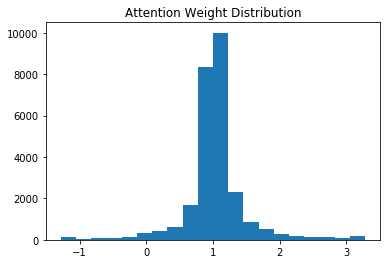

In [34]:
plt.hist(all_weights, bins=20)
plt.title("Attention Weight Distribution")

In [35]:
raw = open('loss_history/AttnExperiment-V2.txt','r').readlines()

In [37]:
raw_accu = [l for l in raw if 'train' in l]

In [39]:
from ast import literal_eval

In [40]:
accu = [literal_eval(d.rstrip('\n')) for d in raw_accu]

In [54]:
attn_duration = [(i,i+1) for i in range(0,20) if i % 5 in [0,2]]
bn_duration = [(i,i+1) for i in range(0,20) if i % 5 in [1,3]]

In [55]:
df = pd.DataFrame.from_dict(accu)

Text(0.5,1,'Adding Batchnorm, Increase Lambda helps boosting val accuracy by 5%')

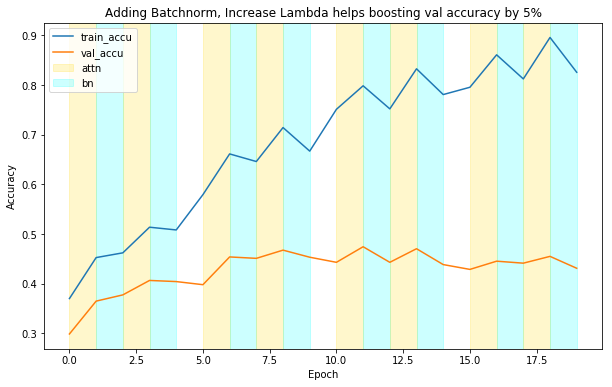

In [56]:
df.plot(figsize=(10,6))
flag = True
for a_d, b_d in zip(attn_duration, bn_duration):
    if flag:
        plt.axvspan(a_d[0], a_d[1], alpha=0.2, color='gold', label='attn')
        plt.axvspan(b_d[0], b_d[1], alpha=0.2, color='cyan', label='bn')
        flag = False
    else:
        plt.axvspan(a_d[0], a_d[1], alpha=0.2, color='gold')
        plt.axvspan(b_d[0], b_d[1], alpha=0.2, color='cyan')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Adding Batchnorm, Increase Lambda helps boosting val accuracy by 5%")

In [57]:
raw_loss = [l for l in raw if 'iter' in l]

In [59]:
raw_loss = [l.strip('\n') for l in raw_loss if '[    1] iter' not in l]

In [63]:
from io import StringIO

In [68]:
df_loss = pd.read_csv(StringIO('\n'.join(raw_loss)), header=None)

In [70]:
df_loss = df_loss.iloc[:,2:]

In [76]:
df_loss.columns

Int64Index([2, 3], dtype='int64')

In [78]:
df_loss[2] = df_loss[2].str.split(': ').apply(lambda x: float(x[1]))
df_loss[3] = df_loss[3].str.split(': ').apply(lambda x: float(x[1]))

/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [81]:
df_loss= df_loss.rename({
    2:'Clf Loss',
    3:'Attn Loss'
}, axis=1)

In [92]:
attn_period = [(i,i+12) for i in np.arange(0,240) if i % 60 in [12, 36]]

Text(0.5,0.98,'Loss Over time')

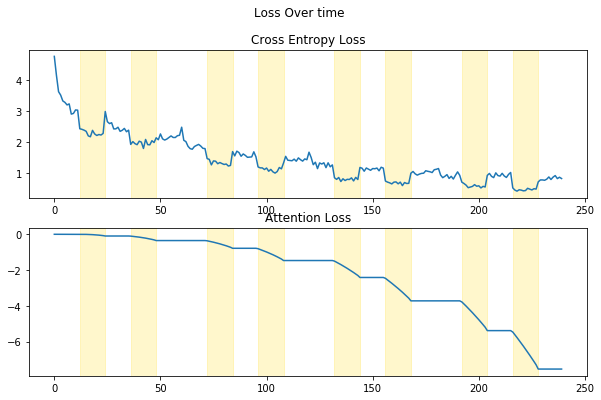

In [94]:
plt.figure(figsize=(10,6))

plt.subplot(211)
plt.title("Cross Entropy Loss")
df_loss['Clf Loss'].plot()
for attn in attn_period:
    plt.axvspan(attn[0], attn[1], alpha=0.2, color='gold')

plt.subplot(212)
plt.title('Attention Loss')
df_loss['Attn Loss'].plot()
for attn in attn_period:
    plt.axvspan(attn[0], attn[1], alpha=0.2, color='gold')

plt.suptitle("Loss Over time")